# Building RNN with Pytorch

Dans ce TD, nous allons construire un RNN from scratch avec Pytorch, en suivant les étapes suivantes:
1. Sur un problème linéaire, nous allons utiliser les torch optimizers pour trouver le paramètre de régression idéal
2. Sur un problème non-linéaire, nous allons construire un multi-layers perceptron
3. Sur un problème de texte, nous allons construire un modèle RNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

## Optimizers

### Données example
Nous allons construire des données $y = \beta^* X + b$


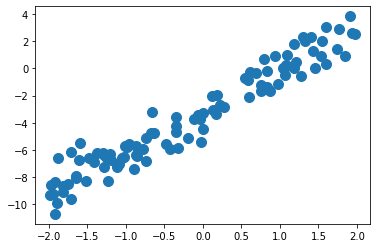

In [2]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * x + b_star + noise

x = torch.tensor(x, dtype=torch.float32)

y = torch.tensor(y, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

### Constuire l'optimizer

- Avec torch.nn.Parameter(), créer le paramètre beta qui sera optimisé. Les predictions du modèle sont égales à $\beta \times X$ 
- Avec torch.nn.MSELoss, déclarer la loss entre les prédictions et le résultat réel. loss.backward() pour mettre à jour les gradients
- Avec torch.optim.Adam, déclarer un optimizer
- Construisez la boucle qui, pour n_epochs, va reset les gradients, calculer la loss, mettre à jour les gradients et faire un pas pour optimiser beta

In [3]:
beta = torch.nn.Parameter(torch.tensor(1.0))  # Paramètre à optimiser
alpha = torch.nn.Parameter(torch.tensor(1.0))  # Paramètre à optimiser
criterion = torch.nn.MSELoss()  # Loss
optimizer = torch.optim.Adam([beta, alpha], lr=0.1)  # Optimizer

n_epochs = 100
for i in range(n_epochs):
    optimizer.zero_grad()  # Reset des gradients
    y_pred = x * beta + alpha  # Prédictions
    loss = criterion(y_pred, y)  # Calcul de la loss
    loss.backward()  # mise à jour des gradients
    optimizer.step()  # Mise à jour des paramètres

    if i % 10 == 0:
        print("Loss:", loss.item())


Loss: 26.671796798706055
Loss: 13.526625633239746
Loss: 6.1566972732543945
Loss: 3.014341115951538
Loss: 1.7428654432296753
Loss: 1.1342802047729492
Loss: 0.9267709851264954
Loss: 0.9078333973884583
Loss: 0.9112938046455383
Loss: 0.9086355566978455


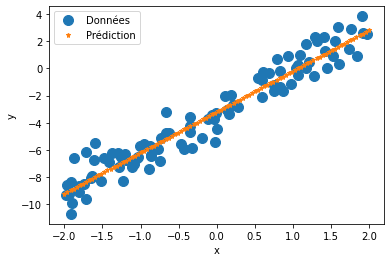

In [4]:
# Affichage des données et de la droite ajustée
xvec = torch.linspace(-2, 2, 100)  # Génère 100 valeurs pour l'affichage
y_pred = beta * xvec + alpha
plt.plot(x, y, 'o', markersize=10, label='Données')
plt.plot(xvec, y_pred.detach(), '*', markersize=5, label='Prédiction')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Construire un multi-layer perceptron (MLP)

Ici, les données sont $y = a x^2 + b$

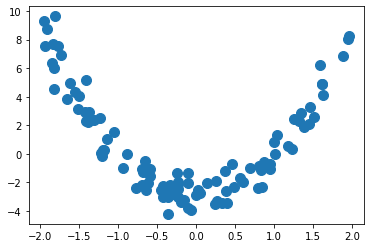

In [5]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * (x ** 2) + b_star + noise

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

Nous allons construire un Pytorch modèle. Dans ce framework, on définit la fonction "forward" qui prend en argument les inputs et retourne les prédictions.

A l'aide de torch.nn.Module et de différentes layers (torch.nn.Linear, torch.nn.ReLU), terminez la classe ci-dessous pour créer un multi-layers perceptron 

In [6]:
# Définir un modèle MLP
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

En utilisant le travail précédent, faite une cellule utilisant un torch optimizer pour optimiser le MLP 

In [7]:
model = MLP(1, 32, 1)
criterion = torch.nn.MSELoss()  # Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Optimizer

n_epochs = 100
for i in range(n_epochs):
    optimizer.zero_grad()  # Reset des gradients
    y_pred = model(x)  # Prédictions
    loss = criterion(y_pred, y)  # Calcul de la loss
    loss.backward()  # mise à jour des gradients
    optimizer.step()  # Mise à jour des paramètres

    if i % 10 == 0:
        print("Loss:", loss.item())

Loss: 12.776091575622559
Loss: 1.2883206605911255
Loss: 0.9627636671066284
Loss: 0.8414241075515747
Loss: 0.8018651008605957
Loss: 0.7792242169380188
Loss: 0.7614870667457581
Loss: 0.7591982483863831
Loss: 0.7551653981208801
Loss: 0.7532901763916016


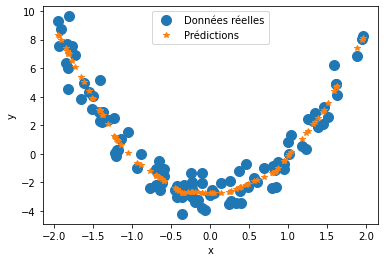

In [8]:
# Afficher le résultat
plt.plot(x, y, 'o', markersize=10, label='Données réelles')
plt.plot(x, y_pred.detach(), '*', linewidth=2, label='Prédictions')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Construire un Recurrent Neural Network (RNN) from scratch

### Aide pour générer les données

A la fin de ce code, on lit les noms et leur pays d'origine.<br>
On a une fonction randomTrainingExample, qui génère le pays d'origine et le nom (en texte), puis l'ID de ce pays et le tenseur représetant le nom. <br>

A partir de là, vous pouvez générer les données X, y comme vous voulez

In [9]:
# Code pour générer le jeu de données
# En admettant que les fichiers ont été extraits dans data/raw/names/

import math
import numpy as np
from pathlib import Path
import random
import string
import time
import unicodedata

path = Path("../data/raw/names/")

In [10]:
def read_names(path):
    category_lines = {}
    for file in path.iterdir():
        if not file.name.endswith(".txt"):
            continue

        with open(file, encoding="utf8") as f:
            names = [unicodeToAscii(line.strip()) for line in f]

        category = file.stem
        category_lines[category] = names

    return category_lines


# Handling ASCII stuff
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [11]:
category_lines = read_names(path)
all_categories = list(category_lines.keys())
n_categories = len(all_categories)

In [12]:
import torch


# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [13]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.int64)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Auttenberg
category = Portuguese / line = Ribeiro
category = Czech / line = Kvasnicka
category = Korean / line = Ku
category = Arabic / line = Bishara
category = Polish / line = Jaskulski
category = Arabic / line = Gerges
category = French / line = Deniau
category = English / line = Forrest
category = German / line = Janson


### Construire le RNN

Un Recurrent Neural Network prend, pour prédire un input X et un hidden state H.<br>
Il output une prédiction et un nouvel hidden state pour la prochaine étape.<br>
Nous allons construire un modèle:

$f(name, H_0) = (proba(\mbox{name from country 0}), proba(\mbox{name from country 1}), \dots)$

Avec $H_0$ un hidden state initial (qui sera appris).

Pour l'instant, nous allons construire un RNN linéaire.<br>
Comme pour le MLP, construisez un torch.nn.Module:
- A l'init, la classe prendra les arguments input_size, hidden_state_dim, output_size
- L'init déclare un paramètre pour l'hidden state initial $H_0$, une layer linéaire prenant (input, hidden_state) -> output_size
- Le forward fonctionnera ainsi:
    - hidden_state = $H_0$
    - For letter in name:
        - x = one-hot encode (letter)
        - output, hidden_state = linear_layer(x, hidden_state)
    - return softmax(output)

In [14]:
from torch import randn


class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_state_dim, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_state_dim
        self.hidden_state = torch.nn.Parameter(randn(hidden_state_dim))  # Paramètre à optimiser
        self.linear = torch.nn.Linear(input_size + hidden_state_dim, hidden_state_dim)  # Layer linéaire
        self.hidden_to_output = torch.nn.Linear(hidden_state_dim, output_size)

    def forward(self, input):
        hidden_state = self.hidden_state  # Ajouter une dimension à hidden_state

        for i in range(input.size()[0]):
            x = input[i]
            combined = torch.cat((x, hidden_state))  # Concaténation de l'input et de l'hidden state
            hidden_state = self.linear(combined)  # Linear layer

        output = self.hidden_to_output(hidden_state)
        return torch.nn.functional.log_softmax(output, dim=0)  # Softmax sur l'output


In [29]:
rnn = RNN(n_letters, 128, n_categories)
learning_rate = 0.0001
rnn.zero_grad()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
n_epochs = 10000

criterion = torch.nn.NLLLoss()
# liste 0 to 1000
epochs = [i for i in range(0, n_epochs, 1000)]
losses = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    category, line, category_tensor, line_tensor = randomTrainingExample()  # Génère un exemple aléatoire
    line_tensor = line_tensor.squeeze()
    output = rnn(line_tensor)
    loss = criterion(output.unsqueeze(0), category_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        losses.append(loss.item())
        print("Loss:", np.mean(losses[-1000:]))

TypeError: randomTrainingExample() missing 1 required positional argument: 'dataloader'

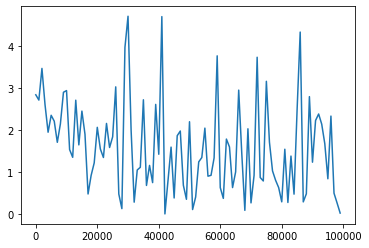

In [16]:
plt.plot(epochs, losses, label='Loss', )

## Utilisez les RNNs de Pytorch

Sur le même jeu de données, nous allons utiliser les RNNs déjà codés par Pytorch.<br>

### Padding

Nous voulons aussi utiliser des tenseurs X et y pour utiliser data loader pour les batchs, etc


Avec du padding, créer un tenseur X de la taille (nb_data, name_max_length, vocab_size). <br>
X[i, j, :] contient le one-hot encode de la j-ème lettre du i-ème prénom. Si le i-ème prénom a moins de j lettre, alors X[i, j, :] est un vecteur nul

In [21]:
# Utiliser data loader pour les batchs
from torch.utils.data import DataLoader, TensorDataset

# Trouver la longueur maximale des prénoms
name_max_length = max(len(name) for names in category_lines.values() for name in names)


# Ajouter du padding aux prénoms
def pad_sequence(sequence, max_length):
    padded_sequence = sequence + [''] * (max_length - len(sequence))
    return padded_sequence


# Créer le tenseur X
def names_to_tensor(names, max_length):
    tensor = torch.zeros(len(names), max_length, n_letters)
    for i, name in enumerate(names):
        padded_name = pad_sequence(list(name), max_length)
        for j, letter in enumerate(padded_name):
            if letter:
                tensor[i][j][letterToIndex(letter)] = 1
    return tensor


# Charger les données
names_tensor = names_to_tensor([name for names in category_lines.values() for name in names], name_max_length)
categories_tensor = torch.tensor(
    [all_categories.index(category) for category, names in category_lines.items() for _ in names],
    dtype=torch.int64)

# Créer le dataset
dataset = TensorDataset(names_tensor, categories_tensor)

# Utiliser DataLoader pour les batchs
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Modifier la fonction randomTrainingExample pour utiliser le DataLoader
def randomTrainingExample(dataloader):
    for batch in dataloader:
        names_tensor, categories_tensor = batch
        return names_tensor, categories_tensor


# Charger les données
names_tensor = names_to_tensor([name for names in category_lines.values() for name in names], name_max_length)

print(names_tensor.shape, categories_tensor.shape)

torch.Size([20074, 19, 57]) torch.Size([20074])


### Modèle

Construisez un modèle qui:
- A l'init, déclare un hidden state initial $H_0$, un RNN (avec torch.nn.RNN)
- Au forward, passe (input, $H_0$) dans le RNN, puis applique un softmax à l'output

In [22]:
import torch.nn as nn


class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_state_dim, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_state_dim
        self.rnn = nn.RNN(input_size, hidden_state_dim)
        self.hidden_to_output = nn.Linear(hidden_state_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.hidden_to_output(output[-1, :, :])  # Prendre seulement la dernière sortie
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)


Entraînez le modèle avec des batchs de X, y

In [25]:
# Créer une instance du modèle
rnn_model = RNNModel(n_letters, 128, n_categories)

# Tester le modèle avec une entrée factice
names_tensor, categories_tensor = randomTrainingExample(dataloader)
batch_size = names_tensor.size(0)
hidden = rnn_model.init_hidden(batch_size)

# Passer à travers le modèle
output, _ = rnn_model(names_tensor.permute(1, 0, 2), hidden)

# Afficher la sortie en log proba
print(output)


tensor([[-2.9600, -2.8991, -2.9163,  ..., -2.9383, -2.8060, -2.8023],
        [-2.9600, -2.8990, -2.9163,  ..., -2.9383, -2.8061, -2.8023],
        [-2.9603, -2.8985, -2.9162,  ..., -2.9385, -2.8068, -2.8024],
        ...,
        [-2.9600, -2.8991, -2.9165,  ..., -2.9383, -2.8061, -2.8024],
        [-2.9599, -2.8991, -2.9163,  ..., -2.9383, -2.8059, -2.8023],
        [-2.9600, -2.8991, -2.9164,  ..., -2.9382, -2.8060, -2.8022]],
       grad_fn=<LogSoftmaxBackward0>)


### Amélioration du modèle

Tenter d'améliorer le modèle:
- En utilisant plusieurs layers dans le RNN
- En utilisant LSTM à la place de RNN (une autre forme de recurrent neural network, plus avancé)

(regardez la doc)

#### Utilisation de plusieurs layers dans le RNN

In [26]:
import torch.nn as nn


class MultiLayerRNNModel(nn.Module):
    def __init__(self, input_size, hidden_state_dim, output_size, num_layers):
        super(MultiLayerRNNModel, self).__init__()
        self.hidden_size = hidden_state_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_state_dim, num_layers=num_layers)
        self.hidden_to_output = nn.Linear(hidden_state_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.hidden_to_output(output[-1, :, :])  # Prendre seulement la dernière sortie
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)


# Créer une instance du modèle avec plusieurs layers
multi_layer_rnn_model = MultiLayerRNNModel(n_letters, 128, n_categories, num_layers=2)


#### Utilisation de LSTM

In [51]:
import torch.nn as nn


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_state_dim, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_state_dim
        self.lstm = nn.LSTM(input_size, hidden_state_dim)
        self.hidden_to_output = nn.Linear(hidden_state_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.hidden_to_output(output[-1, :, :])  # Prendre seulement la dernière sortie
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))


# Créer une instance du modèle avec LSTM
lstm_model = LSTMModel(n_letters, 128, n_categories)

#### Comparaison des modèles

In [52]:
import random
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, classification_report


def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for names_tensor, categories_tensor in dataloader:
            batch_size = names_tensor.size(0)
            hidden = model.init_hidden(batch_size)

            # Passer à travers le modèle
            output, _ = model(names_tensor.permute(1, 0, 2), hidden)
            _, predictions = torch.max(output, 1)

            all_predictions.extend(predictions.tolist())
            all_targets.extend(categories_tensor.tolist())

    accuracy = accuracy_score(all_targets, all_predictions)
    report = classification_report(all_targets, all_predictions, zero_division=1)

    return accuracy, report


# Définir une classe Dataset personnalisée
class NameDataset(Dataset):
    def __init__(self, category_lines, all_categories, letter_to_index):
        self.category_lines = category_lines
        self.all_categories = all_categories
        self.letter_to_index = letter_to_index
        self.max_length = max(len(name) for names in category_lines.values() for name in names)

    def __len__(self):
        return sum(len(names) for names in self.category_lines.values())

    def __getitem__(self, index):
        category = random.choice(self.all_categories)
        line = random.choice(self.category_lines[category])
        category_tensor = torch.tensor([self.all_categories.index(category)], dtype=torch.int64)
        line_tensor = self.line_to_tensor(line)
        return line_tensor, category_tensor

    def line_to_tensor(self, line):
        tensor = torch.zeros(self.max_length, len(self.letter_to_index))
        for i, letter in enumerate(line):
            if letter:
                tensor[i][self.letter_to_index[letter]] = 1
        return tensor


# Créer des ensembles d'entraînement et de test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

n_epochs = 100

# Entraîner le modèle avec plusieurs layers dans le RNN
multi_layer_rnn_model.train()
for epoch in range(n_epochs):
    print(f"Epoch {epoch}/{n_epochs} - Training...")
    for names_tensor, categories_tensor in train_dataloader:
        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Initialiser l'état caché
        hidden = multi_layer_rnn_model.init_hidden(names_tensor.size(0))

        # Passer à travers le modèle
        output, _ = multi_layer_rnn_model(names_tensor.permute(1, 0, 2), hidden)

        # Calculer la perte
        loss = criterion(output, categories_tensor.squeeze())

        # Retropropagation et mise à jour des poids
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}/{n_epochs} - Training complete.")
    # Évaluation à chaque epoch si nécessaire
    if epoch % 100 == 0:
        accuracy_rnn, _ = evaluate_model(multi_layer_rnn_model, test_dataloader)
        print(f"Epoch {epoch}/{n_epochs} - RNN Model - Accuracy: {accuracy_rnn}")

# Entraîner le modèle avec LSTM
lstm_model.train()
for epoch in range(n_epochs):
    print(f"Epoch {epoch}/{n_epochs} - Training...")
    for names_tensor, categories_tensor in train_dataloader:
        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Initialiser l'état caché
        hidden = lstm_model.init_hidden(names_tensor.size(0))

        # Passer à travers le modèle
        output, _ = lstm_model(names_tensor.permute(1, 0, 2), hidden)

        # Calculer la perte
        loss = criterion(output, categories_tensor.squeeze())

        # Retropropagation et mise à jour des poids
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}/{n_epochs} - Training complete.")

    # Évaluation à chaque epoch si nécessaire
    if epoch % 100 == 0:
        accuracy_lstm, _ = evaluate_model(lstm_model, test_dataloader)
        print(f"Epoch {epoch}/{n_epochs} - LSTM Model - Accuracy: {accuracy_lstm}")



Epoch 0/100 - Training...
Epoch 0/100 - Training complete.
Epoch 0/100 - RNN Model - Accuracy: 0.026899128268991282
Epoch 1/100 - Training...
Epoch 1/100 - Training complete.
Epoch 2/100 - Training...
Epoch 2/100 - Training complete.
Epoch 3/100 - Training...
Epoch 3/100 - Training complete.
Epoch 4/100 - Training...
Epoch 4/100 - Training complete.
Epoch 5/100 - Training...
Epoch 5/100 - Training complete.
Epoch 6/100 - Training...
Epoch 6/100 - Training complete.
Epoch 7/100 - Training...
Epoch 7/100 - Training complete.
Epoch 8/100 - Training...
Epoch 8/100 - Training complete.
Epoch 9/100 - Training...
Epoch 9/100 - Training complete.
Epoch 10/100 - Training...
Epoch 10/100 - Training complete.
Epoch 11/100 - Training...
Epoch 11/100 - Training complete.
Epoch 12/100 - Training...
Epoch 12/100 - Training complete.
Epoch 13/100 - Training...
Epoch 13/100 - Training complete.
Epoch 14/100 - Training...
Epoch 14/100 - Training complete.
Epoch 15/100 - Training...
Epoch 15/100 - Traini

### Embedding

On veut utiliser en embedding pour les lettres.
Le forward appliquerait l'embedding aux lettres, puis les layers RNN prendrait l'embedding comme input

Nous allons utiliser torch.nn.Embedding
**Attention**: Embedding ne prend pas les lettres one-hot encoded, mais leurs indices.
Par exemple, "abca", il lui faudrait le vecteur [0, 1, 2, 0]<br>
et non [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]]

**Expérimenter torch.nn.Embedding**<br>
Instantier "emb" une torch.nn.Embedding avec les bons paramètres (regardez la doc)
En construisant le bon tenseur X_emb,

```emb(X_emb)```

doit retourner un tenseur (qui n'a pas de sens car il n'a rien appris pour l'instant, mais les opérations se passent bien)

In [56]:
# Construisez un ensemble de données avec embedding
class NameDatasetWithEmbedding(Dataset):
    def __init__(self, category_lines, all_categories, letter_to_index):
        self.category_lines = category_lines
        self.all_categories = all_categories
        self.letter_to_index = letter_to_index
        self.max_length = max(len(name) for names in category_lines.values() for name in names)

    def __len__(self):
        return sum(len(names) for names in self.category_lines.values())

    def __getitem__(self, index):
        category = random.choice(self.all_categories)
        line = random.choice(self.category_lines[category])
        category_tensor = torch.tensor([self.all_categories.index(category)], dtype=torch.int64)

        # Convertissez la ligne en indices en utilisant le dictionnaire letter_to_index
        line_indices = [self.letter_to_index[letter] for letter in line]

        # Remplissez le reste du tensor avec des zéros pour correspondre à la longueur maximale
        line_tensor = torch.zeros(self.max_length, dtype=torch.long)
        line_tensor[:len(line_indices)] = torch.tensor(line_indices, dtype=torch.long)

        return line_tensor, category_tensor


# Créez un dictionnaire pour mapper chaque lettre à un indice
letters = list(string.ascii_letters + " .,;'")
letter_to_index = {letter: index for index, letter in enumerate(letters)}

print(letters, letter_to_index)

# Taille de l'embedding
embedding_size = 10

# Créez un exemple de dataset avec embedding
embedding_dataset = NameDatasetWithEmbedding(category_lines, all_categories, letter_to_index)

# Créez un dataloader pour l'exemple de dataset
embedding_dataloader = DataLoader(embedding_dataset, batch_size=batch_size, shuffle=True)


# Dans votre modèle RNN
class RNNWithEmbedding(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_state_dim, output_size):
        super(RNNWithEmbedding, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.hidden_size = hidden_state_dim
        self.rnn = nn.RNN(embedding_size, hidden_state_dim)
        self.hidden_to_output = nn.Linear(hidden_state_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Appliquez l'embedding à l'input
        embedded_input = self.embedding(input)

        # Passez à travers le modèle RNN
        output, hidden = self.rnn(embedded_input, hidden)

        # Prenez seulement la dernière sortie
        output = self.hidden_to_output(output[-1, :, :])

        # Appliquez la softmax
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self, batch_size):
        # Initialiser l'état caché avec des zéros
        return torch.zeros(1, batch_size, self.hidden_size)


# Instanciez et entraînez votre modèle RNN avec embedding
rnn_with_embedding_model = RNNWithEmbedding(len(letters), embedding_size, 128, n_categories)
rnn_with_embedding_model.train()

for epoch in range(n_epochs):

    for names_tensor, categories_tensor in embedding_dataloader:
        optimizer.zero_grad()
        hidden = rnn_with_embedding_model.init_hidden(names_tensor.size(0))

        # Obtenez les indices uniques par position dans la séquence
        names_indices_tensor = names_tensor.permute(1, 0).long()

        # Initialisez un tensor pour contenir les indices uniques
        flattened_indices = torch.zeros(names_indices_tensor.size(0) * names_indices_tensor.size(1), dtype=torch.long)

        # Remplissez le tensor avec les indices uniques
        for i in range(names_indices_tensor.size(0)):
            flattened_indices[
            i * names_indices_tensor.size(1):(i + 1) * names_indices_tensor.size(1)] = names_indices_tensor[i, :]

        # Passez à travers le modèle RNN avec embedding
        output, _ = rnn_with_embedding_model(flattened_indices, hidden)
        loss = criterion(output, categories_tensor.squeeze())
        loss.backward()
        optimizer.step()

    # Évaluation à chaque epoch si nécessaire
    if epoch % 100 == 0:
        accuracy_rnn_with_embedding, _ = evaluate_model(rnn_with_embedding_model, test_dataloader)
        print(f"Epoch {epoch}/{n_epochs} - RNN with Embedding Model - Accuracy: {accuracy_rnn_with_embedding}")


['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ', '.', ',', ';', "'"] {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, ' ': 52, '.': 53, ',': 54, ';': 55, "'": 56}


RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

Construisez un modèle RNN, où les lettres passent par l'embedding avant d'être envoyées dans les couches de RNN.
Construisez une loop d'apprentissage

Expérimentez plusieurs valeurs pour le nombre de couche, la taille d'embedding ou les tailles d'hidden state.<br>
Quel neg log likelihood obtenez-vous ?

In [57]:
import torch.nn.functional as F


class RNNWithEmbeddingLayers(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_state_dim, output_size, num_layers=1):
        super(RNNWithEmbeddingLayers, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_state_dim, num_layers=num_layers)
        self.hidden_to_output = nn.Linear(hidden_state_dim, output_size)

    def forward(self, input, hidden):
        embedded_input = self.embedding(input)
        output, hidden = self.rnn(embedded_input, hidden)
        output = self.hidden_to_output(output[-1, :, :])
        output = F.log_softmax(output, dim=1)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.rnn.num_layers, batch_size, self.rnn.hidden_size)


# Instanciez et entraînez votre modèle RNN avec embedding et couches RNN
num_layers_values = [1, 2, 3]  # Expérimentez avec différentes valeurs
embedding_size_values = [16, 32, 64]  # Expérimentez avec différentes valeurs
hidden_state_dim_values = [64, 128, 256]  # Expérimentez avec différentes valeurs

best_model = None
best_neg_log_likelihood = float('inf')

for num_layers in num_layers_values:
    for embedding_size in embedding_size_values:
        for hidden_state_dim in hidden_state_dim_values:
            rnn_with_embedding_layers_model = RNNWithEmbeddingLayers(len(letters), embedding_size, hidden_state_dim,
                                                                     n_categories, num_layers)
            rnn_with_embedding_layers_model.train()

            optimizer = torch.optim.Adam(rnn_with_embedding_layers_model.parameters(), lr=learning_rate)

            for epoch in range(n_epochs):
                for names_tensor, categories_tensor in embedding_dataloader:
                    optimizer.zero_grad()
                    hidden = rnn_with_embedding_layers_model.init_hidden(names_tensor.size(0))
                    output, _ = rnn_with_embedding_layers_model(names_tensor.permute(1, 0).long(), hidden)

                    loss = criterion(output, categories_tensor.squeeze())
                    loss.backward()
                    optimizer.step()

                # Évaluation à chaque epoch si nécessaire
                if epoch % 100 == 0:
                    accuracy, neg_log_likelihood = evaluate_model(rnn_with_embedding_layers_model, test_dataloader)
                    print(f"Epoch {epoch}/{n_epochs} - Accuracy: {accuracy} - Neg Log Likelihood: {neg_log_likelihood}")

            # Comparaison avec le meilleur modèle
            if neg_log_likelihood < best_neg_log_likelihood:
                best_neg_log_likelihood = neg_log_likelihood
                best_model = rnn_with_embedding_layers_model

# Affichage du meilleur modèle et de sa performance
print("Best Model:")
print(best_model)
accuracy, neg_log_likelihood = evaluate_model(best_model, test_dataloader)
print(f"Best Model - Accuracy: {accuracy} - Best Model - Neg Log Likelihood: {neg_log_likelihood}")

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)